## Import necessary packages

In [1]:
%reset # Reset variables when re-running program
# Import packages
import numpy as np
import pandas as pd
import missingno as msno
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import prince
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from rapidfuzz import fuzz

# For exporting plotly graphs to HTML
import plotly.io as pio
pio.renderers.default='notebook'

Don't know how to reset  #, please run `%reset?` for details
Don't know how to reset  reset, please run `%reset?` for details
Don't know how to reset  variables, please run `%reset?` for details
Don't know how to reset  when, please run `%reset?` for details
Don't know how to reset  re-running, please run `%reset?` for details
Don't know how to reset  program, please run `%reset?` for details


## Taking a peak at the data

In [2]:
df = pd.read_csv('churn_raw_data.csv') # Read in the data, and import it to a pandas dataframe
df.dtypes # Find dtypes of every variable in data set

Unnamed: 0                int64
CaseOrder                 int64
Customer_id              object
Interaction              object
City                     object
State                    object
County                   object
Zip                       int64
Lat                     float64
Lng                     float64
Population                int64
Area                     object
Timezone                 object
Job                      object
Children                float64
Age                     float64
Education                object
Employment               object
Income                  float64
Marital                  object
Gender                   object
Churn                    object
Outage_sec_perweek      float64
Email                     int64
Contacts                  int64
Yearly_equip_failure      int64
Techie                   object
Contract                 object
Port_modem               object
Tablet                   object
InternetService          object
Phone   

## 1. Find irrelevant and duplicate observations

In [3]:
print(df.nunique()) # Count unique values in each column
df.duplicated().sum() # Verify no duplicated rows (sum of zero means no duplications)

Unnamed: 0              10000
CaseOrder               10000
Customer_id             10000
Interaction             10000
City                     6058
State                      52
County                   1620
Zip                      8583
Lat                      8563
Lng                      8655
Population               5933
Area                        3
Timezone                   25
Job                       639
Children                   11
Age                        72
Education                  12
Employment                  5
Income                   7506
Marital                     5
Gender                      3
Churn                       2
Outage_sec_perweek       9993
Email                      23
Contacts                    8
Yearly_equip_failure        6
Techie                      2
Contract                    3
Port_modem                  2
Tablet                      2
InternetService             3
Phone                       2
Multiple                    2
OnlineSecu

0

## Mitigate irrelevant and duplicate observations

In [4]:
# Remove irrelevant columns using domain knowledge

# Irrelevant variables, but they will be included in final cleaned dataset
df_trunc = df.drop(['Unnamed: 0', 'CaseOrder', 'Customer_id', 'Interaction', 'Zip', 'Lat', 'Lng'], axis=1) # Remove the unnecessary columns

## 2. View structural errors

In [5]:
# Determine if there are duplicates in text and 'yes/no' columns
yesno = ['Churn', 'Techie', 'Port_modem', 'Tablet', 'Phone', 'Multiple', 'OnlineSecurity', 'OnlineBackup',
    'DeviceProtection', 'TechSupport', 'StreamingMovies', 'StreamingTV', 'PaperlessBilling'] # Columns with Yes/No responses
df_string = df_trunc.drop(yesno, axis=1).select_dtypes(include=['object']) # Drop Yes/No and only columns with text data

df_yesno = df_trunc[yesno] # Dataframe that only consists of yes/no responses
print(df_yesno.nunique()) # Count number of unique values in each yes/no response
print(df_string.nunique()) # Count number of unique values for string responses

for name in df_yesno: # Look at specific values for each Yes/No response
    print(name)
    print(df_yesno[name].unique())

for name in df_string: # To help visualize if there are duplicates
    if name in ['City', 'County', 'Job']: # Drop the high unique value count variables to look at specific values
        pass
    else:
        print(name)
        print(np.unique(df_string[name], return_counts = True))

Churn               2
Techie              2
Port_modem          2
Tablet              2
Phone               2
Multiple            2
OnlineSecurity      2
OnlineBackup        2
DeviceProtection    2
TechSupport         2
StreamingMovies     2
StreamingTV         2
PaperlessBilling    2
dtype: int64
City               6058
State                52
County             1620
Area                  3
Timezone             25
Job                 639
Education            12
Employment            5
Marital               5
Gender                3
Contract              3
InternetService       3
PaymentMethod         4
dtype: int64
Churn
['No' 'Yes']
Techie
['No' 'Yes' nan]
Port_modem
['Yes' 'No']
Tablet
['Yes' 'No']
Phone
['Yes' 'No' nan]
Multiple
['No' 'Yes']
OnlineSecurity
['Yes' 'No']
OnlineBackup
['Yes' 'No']
DeviceProtection
['No' 'Yes']
TechSupport
['No' 'Yes' nan]
StreamingMovies
['Yes' 'No']
StreamingTV
['No' 'Yes']
PaperlessBilling
['Yes' 'No']
State
(array(['AK', 'AL', 'AR', 'AZ', 'CA', 'CO

In [6]:
# Use fuzzjob over fuzzywuzzy because it's more efficient at runtime speed
df_fuzz = df_string[['City', 'County', 'Job']] # Create new dataframe with only high unique count variables

# Job
df_fuzzJob = pd.DataFrame() # Allocate a dataframe for appending
full_names = pd.Series(df_fuzz['Job'].unique()) # only create the data series once, must use data series with fuzzjob
full_names.columns = ['Job']
for index, row1 in full_names.items():
    # skip elements that are already compared
    for row2 in full_names.iloc[index+1::]:
        # use a score_cutoff to improve the runtime for bad matches
        score = fuzz.ratio(row1, row2, score_cutoff=90)
        if score:
            df_fuzzJob = df_fuzzJob.append([[row1, row2, score]])

# City / County
df_fuzzLoc = pd.DataFrame() # Allocate a dataframe for appending
tuple_series = df_string[['City', 'County', 'State']].apply(tuple, axis=1) # Combine City and County because it will offer a more unique key to identify errors
df_fuzz['Loc'] = tuple_series.str.join(', ') # Join the two columns into one column
full_names = pd.Series(df_fuzz['Loc'].unique()) # only create the data series once, must use data series with fuzzjob
full_names.columns = ['Loc']
for index, row1 in full_names.items():
    # skip elements that are already compared
    for row2 in full_names.iloc[index+1::]:
        # use a score_cutoff to improve the runtime for bad matches
        score = fuzz.ratio(row1, row2, score_cutoff=90)
        if score:
            df_fuzzLoc = df_fuzzLoc.append([[row1, row2, score]])

C:\Users\qmeye\AppData\Local\Temp\ipykernel_16508\2291053814.py:14: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\qmeye\AppData\Local\Temp\ipykernel_16508\2291053814.py:19: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\qmeye\AppData\Local\Temp\ipykernel_16508\2291053814.py:28: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\qmeye\AppData\Local\Temp\ipykernel_16508\2291053814.py:28: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\qmeye\AppData\Local\Temp

In [7]:
# Remove all non-ascii characters
df_fuzz['Loc_ascii'] = df_fuzz['Loc'].str.encode('ascii', 'ignore').str.decode('ascii')
# View any non-ascii characters
print(df_fuzz['Loc'][df_fuzz['Loc_ascii']!=df_fuzz['Loc']])

# Remove all non-ascii characters
df_fuzz['Job_ascii'] = df_fuzz['Job'].str.encode('ascii', 'ignore').str.decode('ascii')
# View any non-ascii characters
print(df_fuzz['Job'][df_fuzz['Job_ascii']!=df_fuzz['Job']])

202             Vado, DoÃ±a Ana, NM
815             Anasco, AÃ±asco, PR
1216    Sunland Park, DoÃ±a Ana, NM
1958          Bayamon, BayamÃ³n, PR
2017           Hatch, DoÃ±a Ana, NM
3262            Catano, CataÃ±o, PR
3431         Ensenada, GuÃ¡nica, PR
3609            Manati, ManatÃ­, PR
4038          Bayamon, BayamÃ³n, PR
4909            Manati, ManatÃ­, PR
5045    San German, San GermÃ¡n, PR
5151      Las Cruces, DoÃ±a Ana, NM
6007          Comerio, ComerÃ­o, PR
6485         La Mesa, DoÃ±a Ana, NM
8753          Bayamon, BayamÃ³n, PR
9002          Bayamon, BayamÃ³n, PR
Name: Loc, dtype: object
Series([], Name: Job, dtype: object)


C:\Users\qmeye\AppData\Local\Temp\ipykernel_16508\2795881342.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\qmeye\AppData\Local\Temp\ipykernel_16508\2795881342.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [8]:
# Look for extra white spaces and inconsistent capilization in the text dataset
df_trimmed = df_string.apply(lambda x: x.astype(str).str.lower())
df_trimmed = df_trimmed.apply(lambda x: x.astype(str).str.strip())
df_trimmed = df_trimmed.replace('nan', pd.NA)
df_trimmed.nunique() == df_string.nunique()

City               True
State              True
County             True
Area               True
Timezone           True
Job                True
Education          True
Employment         True
Marital            True
Gender             True
Contract           True
InternetService    True
PaymentMethod      True
dtype: bool

## Fix County Column

In [9]:
# Correct county column
df_trunc['County'] = df_trunc['County'].str.encode('cp1252').str.decode('utf-8')

## 3. Look for unwanted outliers

In [10]:
df_nums = df_trunc.select_dtypes(include=['int', 'float']) # Only columns with continuous, discrete, or ordinal data to visualize basic statistics for each column to determine outliers, by default ignores nans
df_nums.describe()

Population     Children          Age         Income  \
count   10000.000000  7505.000000  7525.000000    7510.000000   
mean     9756.562400     2.095936    53.275748   39936.762226   
std     14432.698671     2.154758    20.753928   28358.469482   
min         0.000000     0.000000    18.000000     740.660000   
25%       738.000000     0.000000    35.000000   19285.522500   
50%      2910.500000     1.000000    53.000000   33186.785000   
75%     13168.000000     3.000000    71.000000   53472.395000   
max    111850.000000    10.000000    89.000000  258900.700000   

       Outage_sec_perweek         Email      Contacts  Yearly_equip_failure  \
count        10000.000000  10000.000000  10000.000000          10000.000000   
mean            11.452955     12.016000      0.994200              0.398000   
std              7.025921      3.025898      0.988466              0.635953   
min             -1.348571      1.000000      0.000000              0.000000   
25%              8.054362     10.000000      0.000000              0.000000   
50%             10.202896     12.000000      1.000000              0.000000   
75%             12.487644     14.000000      2.000000              1.000000   
max             47.049280     23.000000      7.000000              6.000000   

            Tenure  MonthlyCharge  Bandwidth_GB_Year         item1  \
count  9069.000000   10000.000000        8979.000000  10000.000000   
mean     34.498858     174.076305        3398.842752      3.490800   
std      26.438904      43.335473        2187.396807      1.037797   
min       1.000259      77.505230         155.506715      1.000000   
25%       7.890442     141.071078        1234.110529      3.000000   
50%      36.196030     169.915400        3382.424000      3.000000   
75%      61.426670     203.777441        5587.096500      4.000000   
max      71.999280     315.878600        7158.982000      7.000000   

              item2         item3         item4         item5         item6  \
count  10000.000000  10000.000000  10000.000000  10000.000000  10000.000000   
mean       3.505100      3.487000      3.497500      3.492900      3.497300   
std        1.034641      1.027977      1.025816      1.024819      1.033586   
min        1.000000      1.000000      1.000000      1.000000      1.000000   
25%        3.000000      3.000000      3.000000      3.000000      3.000000   
50%        4.000000      3.000000      3.000000      3.000000      3.000000   
75%        4.000000      4.000000      4.000000      4.000000      4.000000   
max        7.000000      8.000000      7.000000      7.000000      8.000000   

              item7         item8  
count  10000.000000  10000.000000  
mean       3.509500      3.495600  
std        1.028502      1.028633  
min        1.000000      1.000000  
25%        3.000000      3.000000  
50%        4.000000      3.000000  
75%        4.000000      4.000000  
max        7.000000      8.000000

In [11]:
print(df_nums['Population'][df_nums['Population']==0])
print(df_nums['Outage_sec_perweek'][df_nums['Outage_sec_perweek']<0])

13      0
422     0
428     0
434     0
446     0
       ..
9216    0
9441    0
9657    0
9702    0
9944    0
Name: Population, Length: 97, dtype: int64
1904   -1.195428
1997   -0.339214
3069   -0.206145
3629   -0.152845
4167   -1.348571
4184   -0.352431
4427   -1.099934
6093   -0.787115
6463   -0.144644
6577   -0.527396
8194   -0.214328
Name: Outage_sec_perweek, dtype: float64


In [12]:
fig = make_subplots(rows=int(np.floor(len(df_nums.iloc[0,:])/3)+1), cols=3,
    subplot_titles=df_nums.columns) # Create subplots

row_num = 1
col_num = 1
for name in df_nums: # Create histogram for each column in df_nums
    fig.add_trace(
        go.Histogram(x=df_nums[name]),
        row=row_num, col=col_num)
    col_num += 1
    if col_num == 4:
        col_num = 1
        row_num += 1

fig.update_layout(width=2000, height=2000) # Resize figure
fig.show()

## Fix outliers

In [13]:
df_trunc['Population'][df_trunc['Population']==0] = np.nan # Set to nan to be imputated
df_trunc['Outage_sec_perweek'][df_trunc['Outage_sec_perweek']<0] = 0 # Set zero

C:\Users\qmeye\AppData\Local\Temp\ipykernel_16508\3709837410.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\qmeye\AppData\Local\Temp\ipykernel_16508\3709837410.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [14]:
print(df_trunc['Population'][df_trunc['Population'].isnull()])
print(df_trunc['Outage_sec_perweek'][df_trunc['Outage_sec_perweek'].isnull()])

13     NaN
422    NaN
428    NaN
434    NaN
446    NaN
        ..
9216   NaN
9441   NaN
9657   NaN
9702   NaN
9944   NaN
Name: Population, Length: 97, dtype: float64
Series([], Name: Outage_sec_perweek, dtype: float64)


## 4. Assess for missing data

<AxesSubplot:>

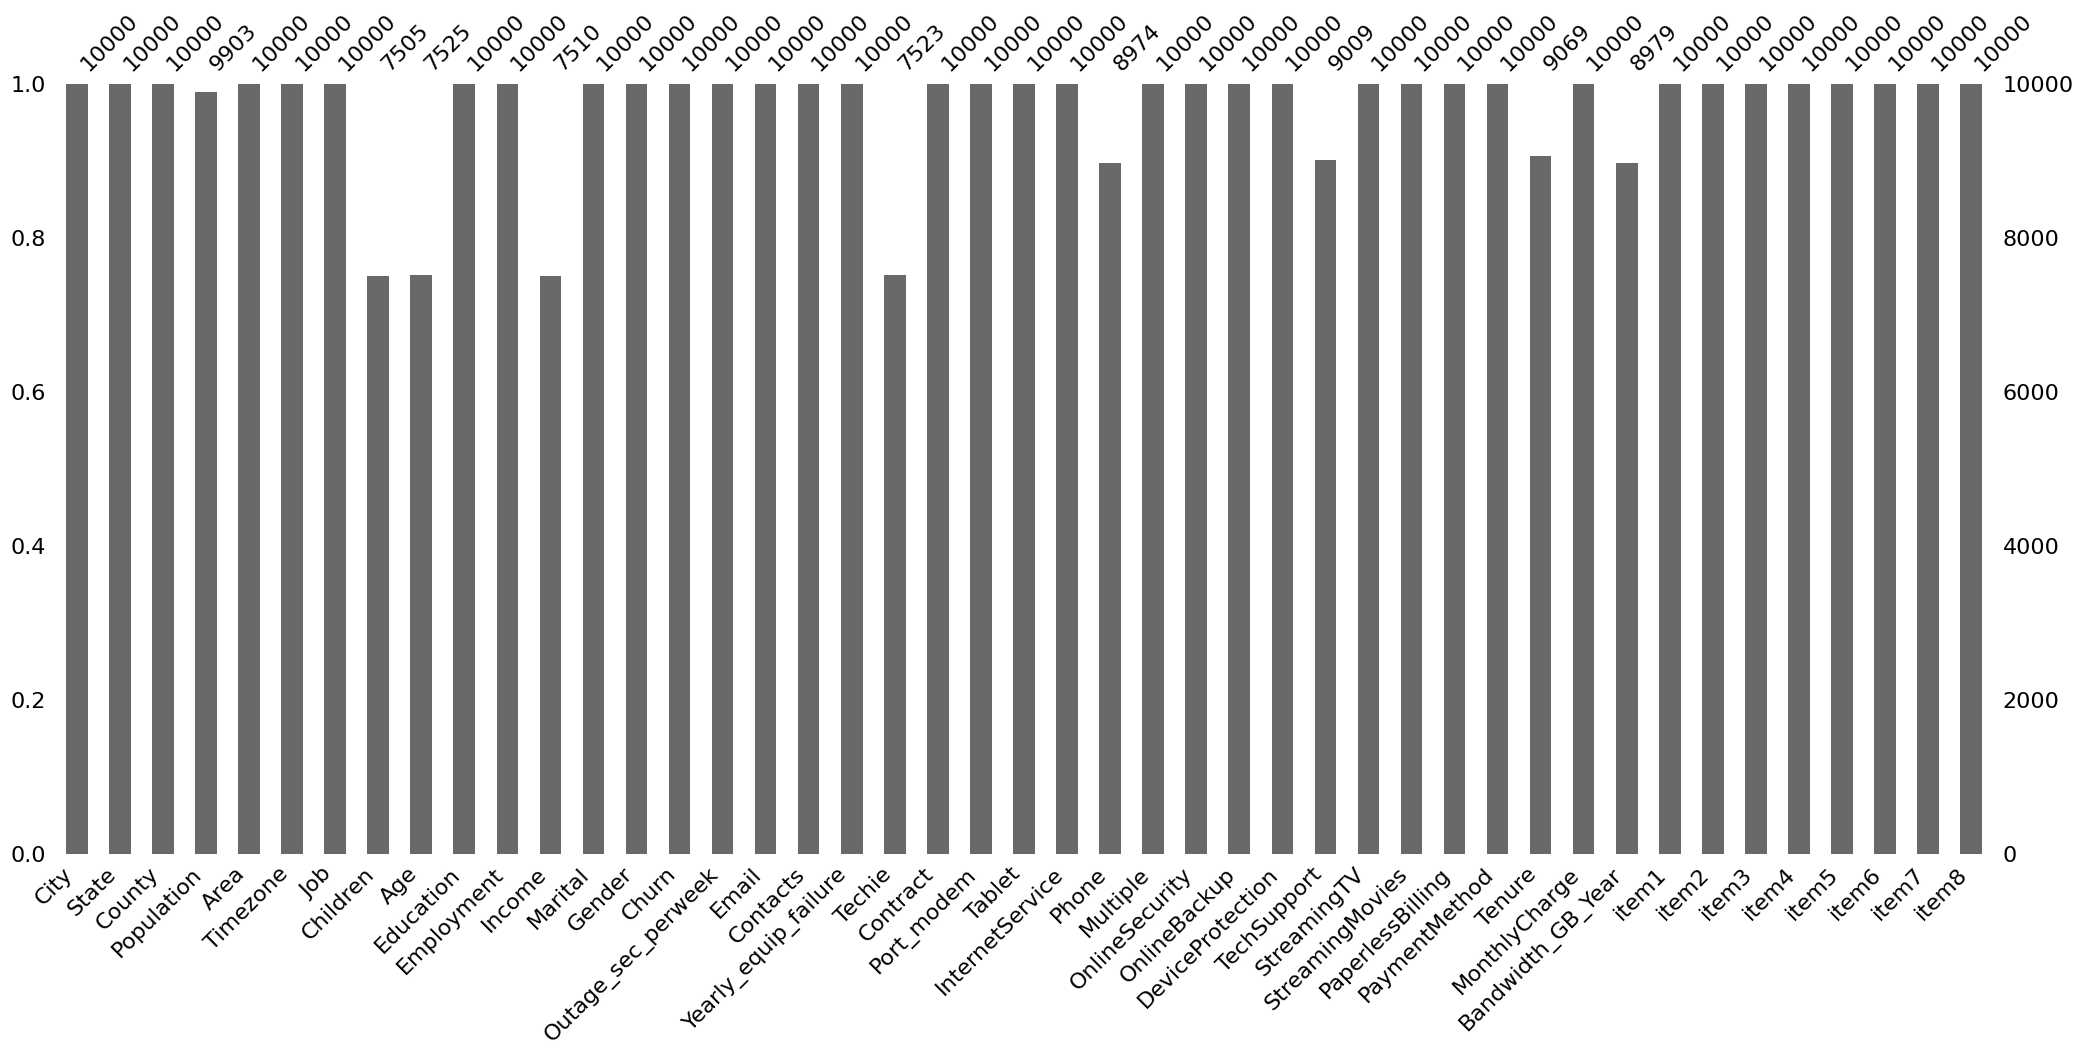

In [15]:
msno.bar(df_trunc) # Look at number of nans in dataset

<AxesSubplot:>

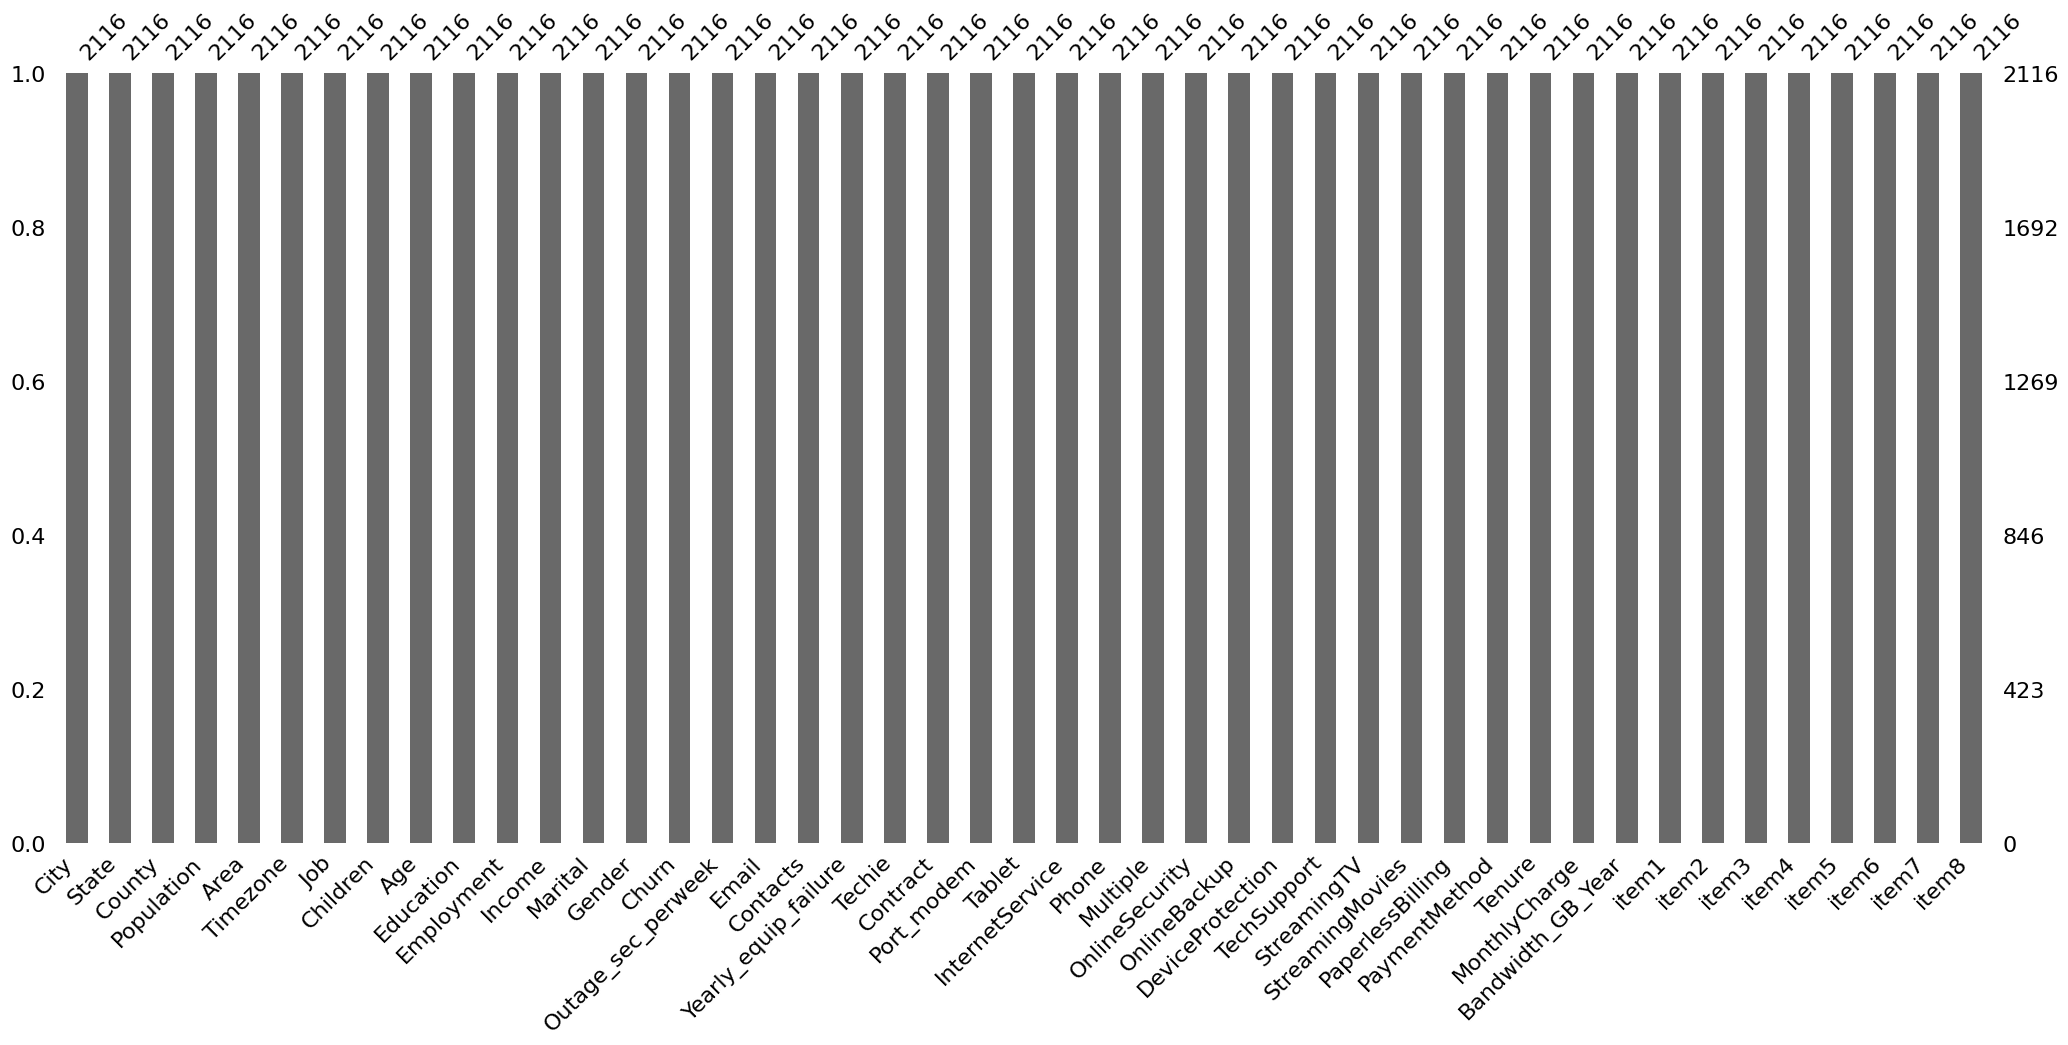

In [16]:
df_dropna = df_trunc.dropna() # Use .dropna() method to drop all nans from df_trunc
msno.bar(df_dropna) # Plot all of the rows with complete data values

## Imputate missing data

In [17]:
df_preImpute = df_nums.assign(Techie=df_trunc['Techie'],
    Phone=df_trunc['Phone'],
    TechSupport=df_trunc['TechSupport']) # Add nan yes/no columns to a pre-imputed dataframe full of nans

yesno_impute = ['Techie', 'Phone', 'TechSupport'] # List of column names for the columns containing nans
for name in yesno_impute:
    df_preImpute[name] = df_preImpute[name].map({'Yes': 1, 'No': 0}) # Change Yes/No into 1/0 to be imputed

col_names = list(df_preImpute) # Get a list of column names to insert after imputation
impute_it = IterativeImputer() # Use IterativeImputer from Scikit-Learn due to domain-level properties
df_postImpute = pd.DataFrame(impute_it.fit_transform(df_preImpute)) # Imputate data and convert from series to pandas dataframe
df_postImpute.columns = col_names # Reinsert column names to data

df_nans = df_trunc.loc[:, df_trunc.isnull().any()] # Get dataframe only consisting of columns with nanas
nan_dict = {'Children': 0, 'Age': 0, 'Techie': 0, 'Phone': 0, 'TechSupport': 0} # Dictionary for line below
df_postImpute = df_postImpute.round(nan_dict) # Round to integer because children, age, and yes/no questions have to be whole numbers

df_postImpute[df_nans.columns].describe() - df_preImpute[df_nans.columns].describe() # Quickly check to make sure no anomalies after imputation

Population     Children          Age       Income       Techie  \
count         0.0  2495.000000  2475.000000  2490.000000  2477.000000   
mean          0.0     0.001264    -0.064248     0.035216    -0.041388   
std           0.0    -0.248265    -2.412521 -3783.354185    -0.041551   
min           0.0     0.000000     0.000000     0.000000     0.000000   
25%           0.0     1.000000     5.000000  4375.267500     0.000000   
50%           0.0     1.000000     1.000000  6745.384080     0.000000   
75%           0.0     0.000000    -5.000000 -7968.202500     0.000000   
max           0.0     0.000000     0.000000     0.000000     0.000000   

             Phone  TechSupport      Tenure  Bandwidth_GB_Year  
count  1026.000000   991.000000  931.000000        1021.000000  
mean      0.009672    -0.034514    0.038100          -6.395983  
std      -0.013924    -0.010292   -0.117570         -11.557707  
min       0.000000     0.000000   -4.174560           0.000000  
25%       0.000000     0.000000    0.098450           1.257381  
50%       0.000000     0.000000   -1.408207           7.934274  
75%       0.000000     0.000000   -0.072288         -14.518750  
max       0.000000     0.000000    4.194461           0.000000

<AxesSubplot:>

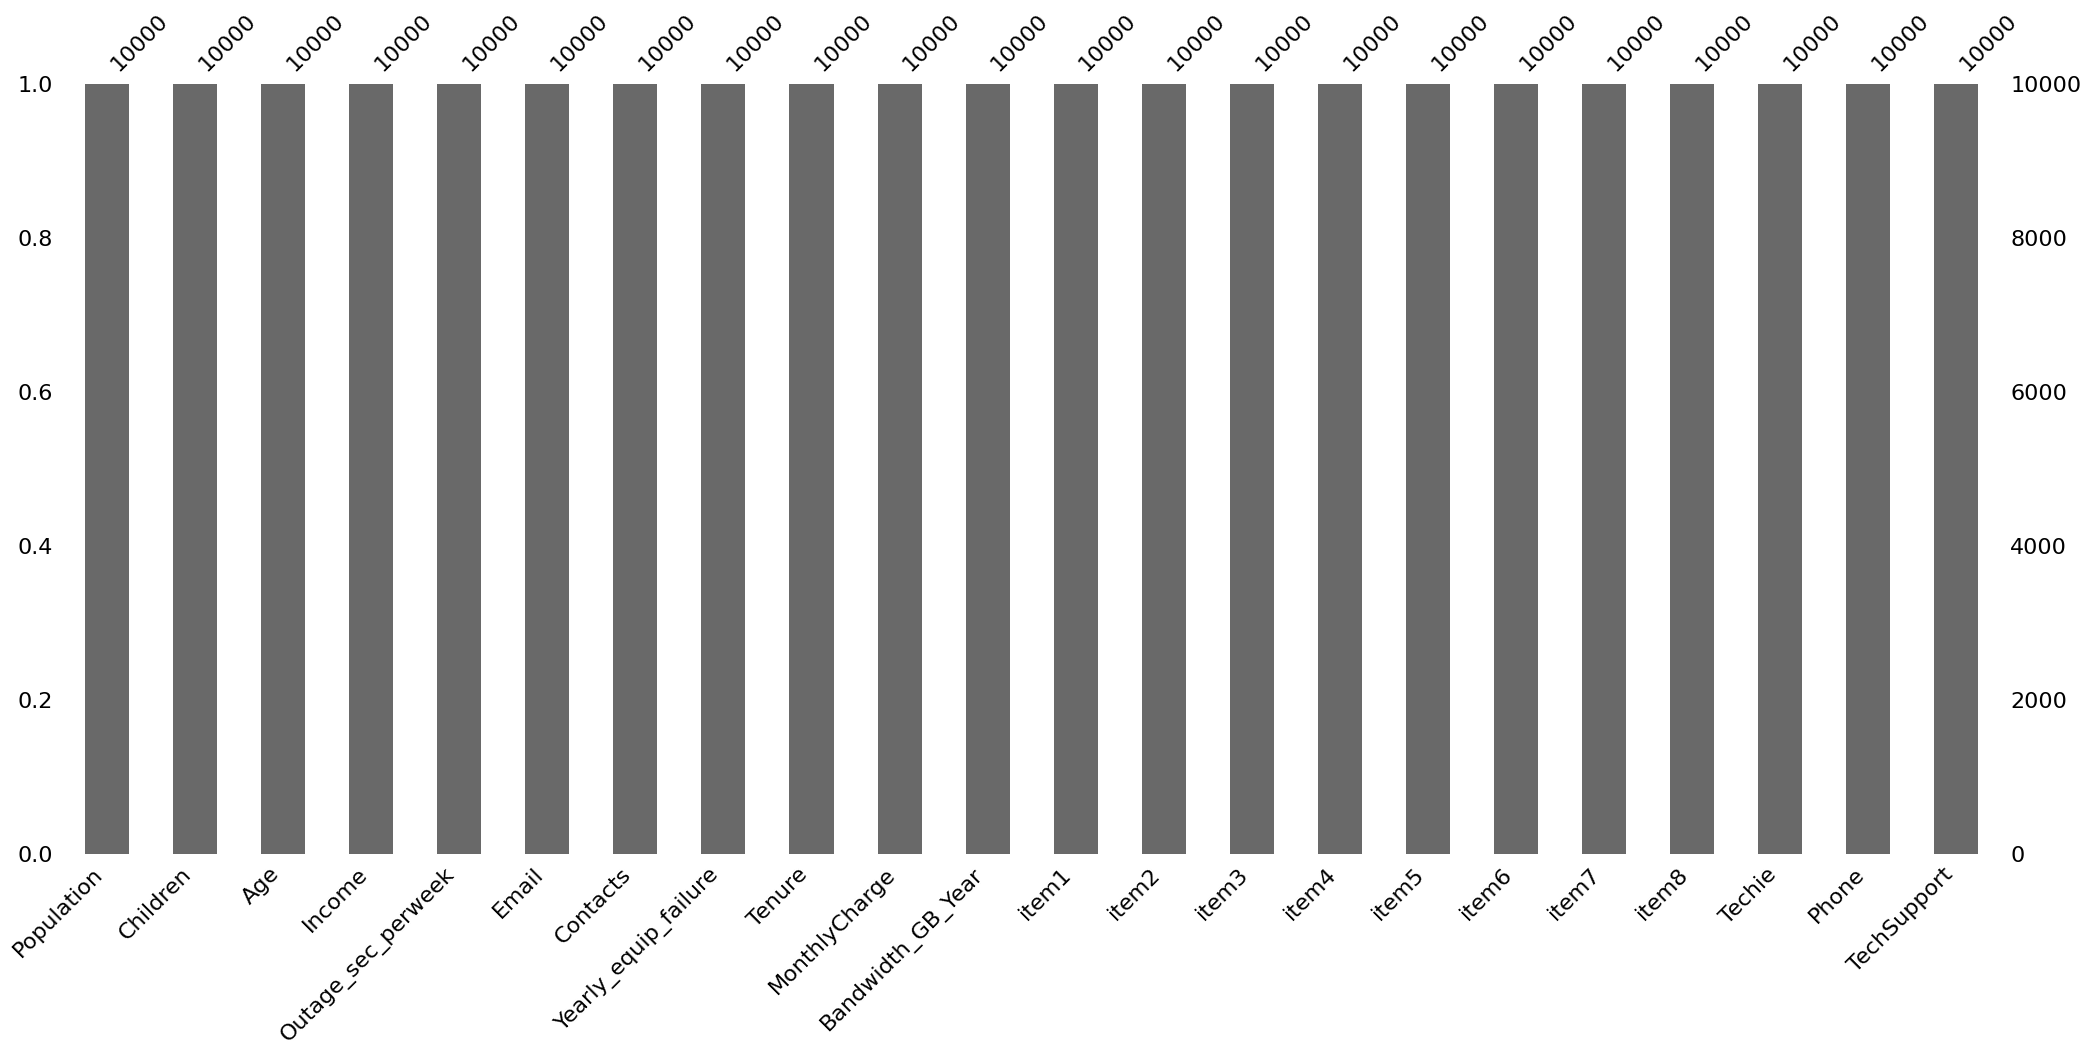

In [18]:
msno.bar(df_postImpute) # Check to make sure every value imputated

<AxesSubplot:>

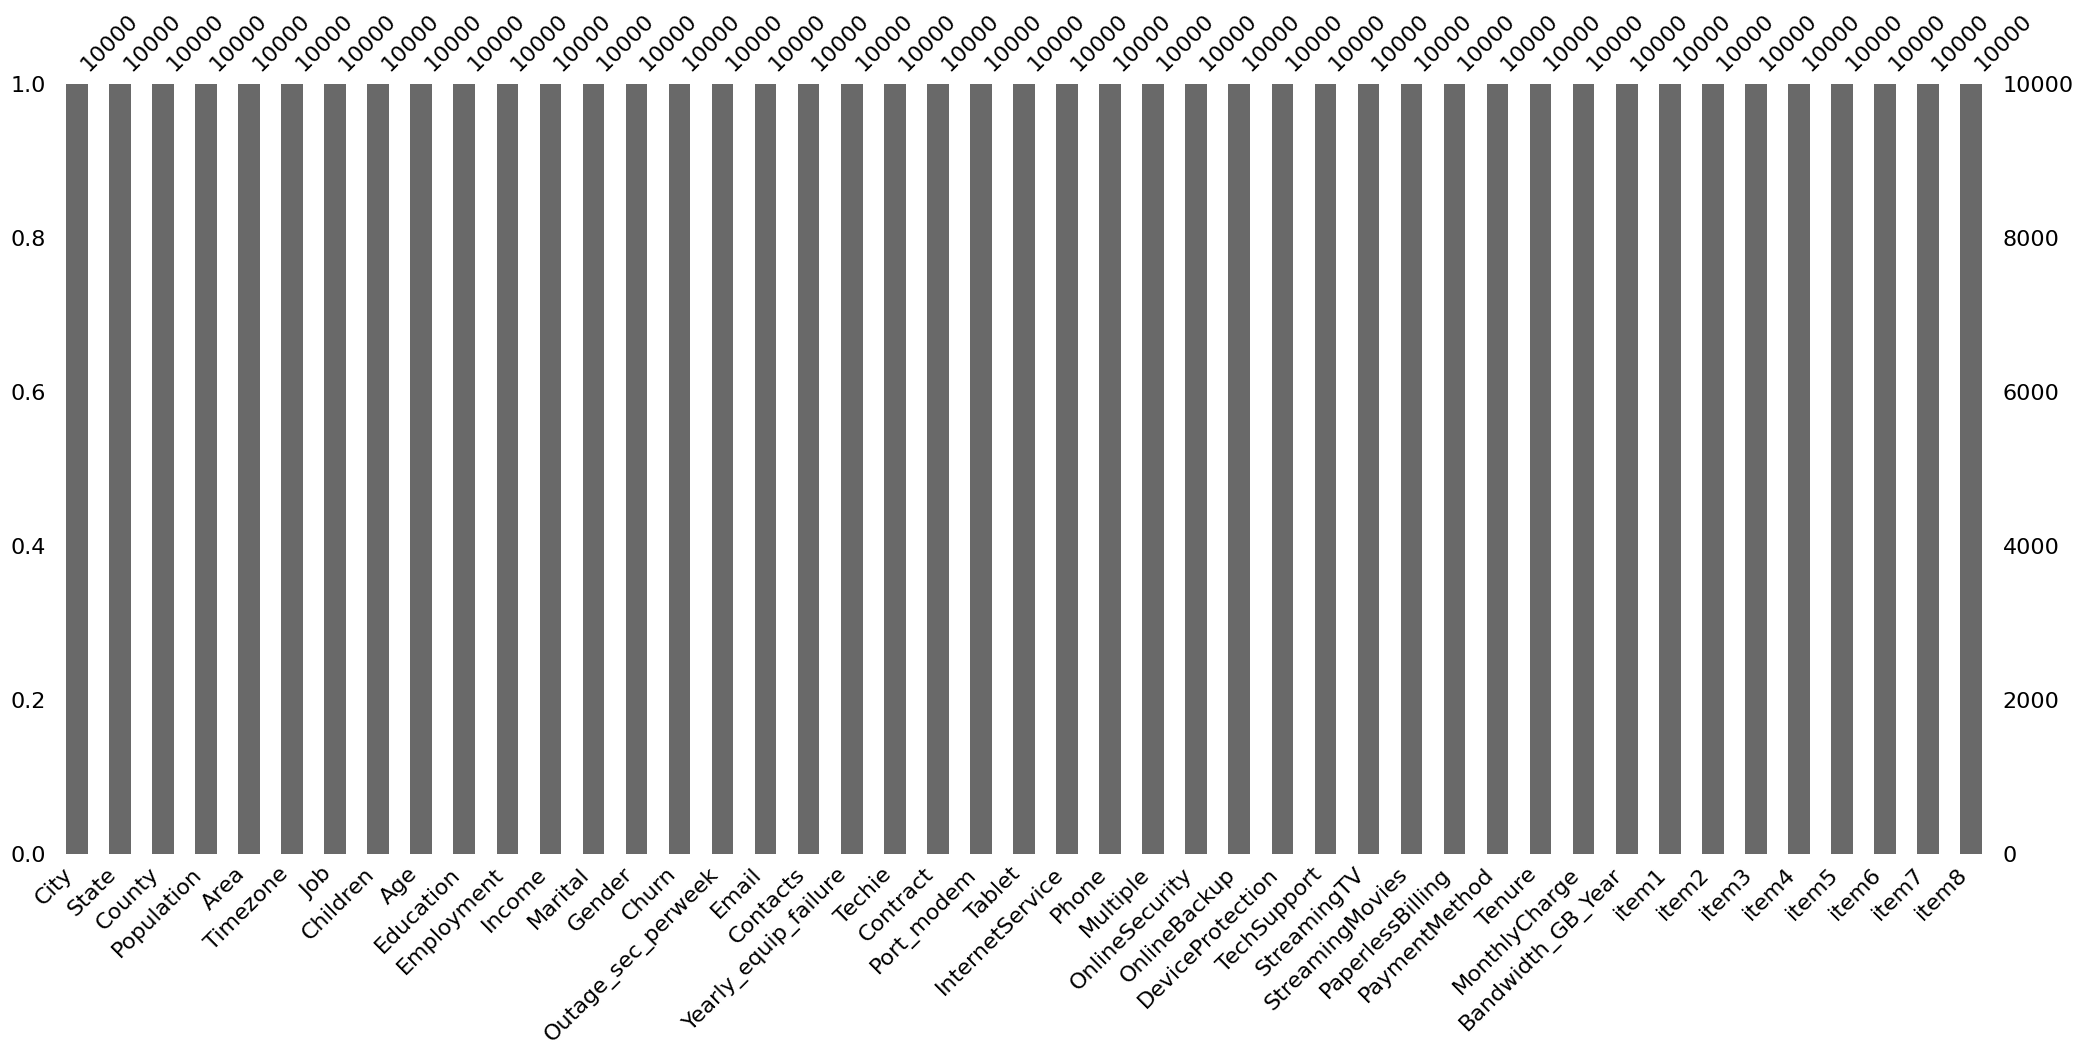

In [19]:
df_trunc[df_nans.columns] = df_postImpute[df_nans.columns] # Replace nan columns with imputated columns

for name in yesno_impute:
    df_trunc[name] = df_trunc[name].map({1: 'Yes', 0: 'No'}) # Change 1/0 from post-imputed data back into 'Yes'/'No'

    
msno.bar(df_trunc) # Verify final dataframe contains the imputated data

## Perform Primary Component Analysis (PCA) on the data
###### (3), (4)

In [20]:
X = df_trunc.select_dtypes(include=['int', 'float']) # Only columns with continuous, numerical data

num = len(X.iloc[0,:]) # Number of variables in the dataset
pca = prince.PCA(n_components=num, # Principal Components initially set to number of variables
    rescale_with_mean=True,  # Data needs to be mean averaged
    rescale_with_std=True,  # Data needs to be rescaled with standard deviation
    copy=True) # Use Prince for PCA package
pca = pca.fit(X) # Fit PCA to the continuous, numerical data
df_pca = pca.transform(X) # Store principal components in a dataframe
df_pca.head()

0         1         2         3         4         5         6   \
0  1.944874 -1.366942  1.873342 -0.285366  0.426982  1.061447 -1.371010   
1 -0.205197 -1.609115  0.470340  1.403227  0.679678 -0.532292 -1.073080   
2 -0.665536 -0.906430  0.240572 -0.248203  1.711452  0.722727 -0.752110   
3  0.046286 -0.766017  2.198629 -0.320312 -1.179104 -1.006965 -0.032012   
4  1.348902 -1.876214  0.747624 -0.420573 -1.944505  0.676703 -0.679731   

         7         8         9         10        11        12        13  \
0 -0.390978  0.193591 -0.768915  0.055475 -0.300421  0.100709 -0.824700   
1 -0.134819  1.080779  0.185565 -0.770194 -1.233855  0.758356  0.820557   
2  0.093893  0.214800 -0.178452  0.385656 -0.040738 -0.208261 -0.398558   
3 -0.248335 -0.322148  1.015867 -0.428861  1.287147 -0.180805  0.184105   
4  0.833158 -1.167786 -0.300700 -0.806627  0.357604  1.199190  0.383447   

         14        15        16        17        18  
0  0.242113 -0.128396 -0.023786 -0.011898 -0.041747  
1 -0.459541  0.211437 -0.474137 -0.681467 -0.047196  
2 -0.288604  1.007508 -1.336882  0.400705  0.053924  
3  0.825993  0.398335  0.201350 -0.037760  0.137067  
4 -0.023544  0.126691  0.205891 -0.104889 -0.040149

In [21]:
# Plot the Eigenvalues and Scree Plot

fig = make_subplots(rows=1, cols=2,
    subplot_titles=("Eigenvalues", "Scree Plot")) # Initiate subplots with Plotly

eigs = pca.eigenvalues_ # Get eigenvalues from Prince
fig.add_trace(
    go.Scatter(x=np.arange(len(eigs)), y=eigs),
    row=1, col=1) # Create a plot with eigenvalues
fig.update_xaxes(title_text="Principal Components", row=1, col=1)
fig.update_yaxes(title_text="Eigenvalues", row=1, col=1)
fig.add_trace(
    go.Bar(x=np.arange(len(eigs)), y=eigs/np.sum(eigs)*100),
    row=1, col=2) # Create a plot with prinipal component intertia
fig.update_xaxes(title_text="Principal Components", row=1, col=2)
fig.update_yaxes(title_text="Percentage of explained variance", row=1, col=2)

## Additional work on PCA (extra)

In [22]:
# View certain dimensions of the principal components

MC = X['MonthlyCharge'].copy() # Get 'MonthlyCharge' column, and store in new dataframe
high_val = 175 # Values greater than mean are considered 'high value' in this case; derived from .describe() method 
MC[MC<=high_val] = 0 # Set high values less than high_val to zero
MC[MC>high_val] = 1 # Set high values less than high_val to one
MC = MC.map({1: 'High_Value', 0: 'Low_Value'}) # Map new binary values to MonthlyCharge (MC)

x = df_pca.iloc[:,0] # FinalDataSet = FeatureVector * StandardizedOriginalDataSet.T
y = df_pca.iloc[:,1]
z = df_pca.iloc[:,2] # Only first 3 principal components for visualization purposes

df_recast = pd.DataFrame()
df_recast['x'] = x # Put variables into a single dataframe for Plotly use
df_recast['y'] = y
df_recast['z'] = z
df_recast['MC'] = MC

fig = px.scatter_3d(df_recast, x='x', y='y', z='z', color=MC) # 3D scatterplot
fig.show()

In [23]:
# First 3 principal components do not separate high from low value customers
# Use column correlations to find the principal components with the most influence

temp = pca.column_correlations(X)
print(temp)
print(np.abs(temp.loc['MonthlyCharge']).argsort())

                            0         1         2         3         4   \
Age                   0.015432 -0.014848 -0.011581 -0.051657 -0.472582   
Bandwidth_GB_Year    -0.027723  0.995520 -0.070171 -0.013251  0.006955   
Children              0.004575  0.009829  0.018193 -0.007471  0.609986   
Contacts             -0.014686  0.003841 -0.013321 -0.008986 -0.470005   
Email                 0.014961 -0.027677 -0.006227  0.058255 -0.222958   
Income               -0.001518  0.006601  0.033140 -0.000718  0.220797   
MonthlyCharge        -0.001141  0.060771 -0.029967  0.740985 -0.103719   
Outage_sec_perweek   -0.022813  0.025685 -0.060247  0.749424  0.055189   
Population           -0.003578 -0.007370  0.020358 -0.044282 -0.254055   
Tenure               -0.026553  0.993088 -0.070146 -0.057386 -0.026777   
Yearly_equip_failure -0.013333  0.026090  0.009287  0.059513  0.241827   
item1                 0.787598  0.039959  0.359136  0.033833  0.008724   
item2                 0.745199  0.0513

In [24]:
# what if we only include the primary principal component (0), and one of the influential principal components?

x = df_pca.iloc[:,0] # FinalDataSet = FeatureVector * StandardizedOriginalDataSet.T
y = df_pca.iloc[:,1] # Only first 3 principal components for visualization purposes
z = df_pca.iloc[:,3] # 4th column has highest correlation to MonthlyCharge, use to visualize difference


df_recast = pd.DataFrame()
df_recast['x'] = x # Put variables into a single dataframe for Plotly use
df_recast['y'] = y
df_recast['z'] = z
df_recast['MC'] = MC

fig = px.scatter_3d(df_recast, x='x', y='y', z='z', color=MC) # 3D scatterplot
fig.show()

In [25]:
# What if we include the primary principal component, and the two most influential principal components?

x = df_pca.iloc[:,0] # FinalDataSet = FeatureVector * StandardizedOriginalDataSet.T
y = df_pca.iloc[:,3] # Only first 3 principal components for visualization purposes
z = df_pca.iloc[:,11] # 11th column has 2nd highest correlation to MonthlyCharge, use to visualize difference again

df_recast['x'] = x # Put variables into a single dataframe for Plotly use
df_recast['y'] = y
df_recast['z'] = z
df_recast['MC'] = MC

fig = px.scatter_3d(df_recast, x='x', y='y', z='z', color=MC) # 3D scatterplot
fig.show()

In [26]:
# Extras needed for submission criteria

# Finalize 'clean' data set, and export to csv file
# df[df_nans.columns] = df_postImpute[df_nans.columns] # Must include clean data set with complete list of variables
# df.to_csv('churn_clean_data.csv', index=True) # Write final complete df to csv - commented out to conserve memory

# Export PCA results to csv file
# df_pca.to_csv('pca_data.csv', index=True) # commented out to conserve memory